In [129]:
#import packages

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import glob

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib 
import zipfile 

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering 

import scipy.cluster as scp

%matplotlib inline

In [2]:
# Make sure the environmental variable works
puidata = os.getenv("PUIDATA")
if not puidata or puidata == 'nfshome/tm1722/PUIdata':
    puidata = '/nfshome/tm1722/PUIDATA'
    
os.environ["PUIDATA"] = puidata

# Time series clustering exercise

### TASKS:   
  +  1. get and prep your data.
    
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means
    in **a few** clusters (as discussed there is no real good, sound way to 
    decide what a good number is here. try a few options, keeping in mind 
    a few is more than a couple, but i recommand you stay within the 
    single digit numbers)
    
    3. plot the cluster centers (if you used K means those are the means of 
    the clusters). you can plot for example the cluster centers overlayed on 
    each time series (using the alpha channel to control the opacity in the 
    plot may be helpful here).
    
    4. Use another clustering algorithm (of your choice)
    
    5. overlay your data on a NYC map: you can use shapefiles for the 
    zip codes and different colors for different clusters
    
    6. Compare the results of the 2 algorithms
    
    7. attempt an interpretation. this is dangerous ground: clustering is 
    an exploratory tool so you do not want to jump to conclusions because 
    you see some clusters! but seeing structure in your data can inform 
    your next moves as an investigator. 
    

## Obtaining Data

In [3]:
# Download the shapefile using urllib, extract zip
urllib.urlretrieve('https://data.cityofnewyork.us/api/views/i8iw-xf4u/files/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip',
                   puidata + '/zipcodes.zip')
zip_ref = zipfile.ZipFile(puidata + '/zipcodes.zip', 'r')
zip_ref.extractall(puidata)
zip_ref.close()


In [4]:
# Read the shape file in a geopandas dataframe
zipshp = gpd.GeoDataFrame.from_file(puidata + 
                                    '/ZIP_CODE_040114.shp')


In [5]:
# Download data from GitHub

zip_list = ['/zbp00totals.zip',
        '/zbp01totals.zip',
        '/zbp02totals.zip',
        '/zbp03totals.zip',
        '/zbp04totals.zip',
        '/zbp05totals.zip',
        '/zbp06totals.zip',
        '/zbp07totals.zip',
        '/zbp08totals.zip',
        '/zbp09totals.zip',
        '/zbp10totals.zip',
        '/zbp11totals.zip',
        '/zbp12totals.zip',
        '/zbp13totals.zip',
        '/zbp94totals.zip',
        '/zbp95totals.zip',
        '/zbp96totals.zip',
        '/zbp97totals.zip',
        '/zbp98totals.zip',
        '/zbp99totals.zip']

for i in zip_list:
    
    urllib.urlretrieve('https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55' + i,
                   puidata + i)
    zip_ref = zipfile.ZipFile(puidata + i, 'r')
    zip_ref.extractall(puidata)
    zip_ref.close()

## Data cleaning

In [6]:
df = pd.read_csv(puidata + '/zbp94totals.txt')

#df.shape
#df.columns

# keep only zipcodes and # of establishments
df = df[['zip', 'est']]
#df.shape

zip_txt = ['/zbp95totals.txt',
           '/zbp96totals.txt',
           '/zbp97totals.txt',
           '/zbp98totals.txt',
           '/zbp99totals.txt',
           '/zbp00totals.txt',
           '/zbp01totals.txt',
           '/zbp02totals.txt',
           '/zbp03totals.txt',
           '/zbp04totals.txt',
           '/zbp05totals.txt',
           '/zbp06totals.txt',
           '/zbp07totals.txt',
           '/zbp08totals.txt',
           '/zbp09totals.txt',
           '/zbp10totals.txt',
           '/zbp11totals.txt',
           '/zbp12totals.txt',
           '/zbp13totals.txt']



for i in zip_txt:
    df_95_13 = pd.read_csv(puidata + i)
    df_95_13.columns = df_95_13.columns.str.lower() # convert to strings
    df_95_13 = df_95_13[['zip', 'est']]
    df = df.join(df_95_13.set_index('zip'), on='zip', how='outer', rsuffix=i) # change this?



In [7]:
df.head()

,zip,est,est/zbp95totals.txt,est/zbp96totals.txt,est/zbp97totals.txt,est/zbp98totals.txt,est/zbp99totals.txt,est/zbp00totals.txt,est/zbp01totals.txt,est/zbp02totals.txt,...,est/zbp04totals.txt,est/zbp05totals.txt,est/zbp06totals.txt,est/zbp07totals.txt,est/zbp08totals.txt,est/zbp09totals.txt,est/zbp10totals.txt,est/zbp11totals.txt,est/zbp12totals.txt,est/zbp13totals.txt
0,1001.0,439.0,439.0,433.0,457.0,444.0,469.0,493.0,490.0,490.0,...,500.0,509.0,509.0,503.0,477.0,458.0,448.0,436.0,453.0,439.0
1,1002.0,450.0,467.0,487.0,500.0,490.0,558.0,563.0,587.0,566.0,...,584.0,589.0,582.0,596.0,584.0,571.0,570.0,558.0,572.0,572.0
2,1003.0,10.0,10.0,13.0,15.0,14.0,13.0,13.0,13.0,15.0,...,15.0,12.0,12.0,16.0,17.0,16.0,16.0,16.0,15.0,15.0
3,1004.0,47.0,48.0,47.0,41.0,31.0,35.0,48.0,37.0,23.0,...,43.0,31.0,30.0,20.0,18.0,18.0,21.0,19.0,16.0,16.0
4,1005.0,92.0,95.0,101.0,104.0,95.0,82.0,86.0,90.0,94.0,...,97.0,94.0,98.0,106.0,97.0,87.0,96.0,91.0,94.0,97.0


In [8]:
df = df.rename(columns={'est':'1994',
                  'est/zbp95totals.txt':'1995',
                  'est/zbp96totals.txt':'1996',
                  'est/zbp97totals.txt':'1997',
                  'est/zbp98totals.txt':'1998',
                  'est/zbp99totals.txt':'1999',
                  'est/zbp00totals.txt':'2000',
                  'est/zbp01totals.txt':'2001',
                  'est/zbp02totals.txt':'2002',
                  'est/zbp03totals.txt':'2003',
                  'est/zbp04totals.txt':'2004',
                  'est/zbp05totals.txt':'2005',
                  'est/zbp06totals.txt':'2006',
                  'est/zbp07totals.txt':'2007',
                  'est/zbp08totals.txt':'2008',
                  'est/zbp09totals.txt':'2009',
                  'est/zbp10totals.txt':'2010',
                  'est/zbp11totals.txt':'2011',
                  'est/zbp12totals.txt':'2012',
                  'est/zbp13totals.txt':'2013'})
df.head()

,zip,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,1001.0,439.0,439.0,433.0,457.0,444.0,469.0,493.0,490.0,490.0,...,500.0,509.0,509.0,503.0,477.0,458.0,448.0,436.0,453.0,439.0
1,1002.0,450.0,467.0,487.0,500.0,490.0,558.0,563.0,587.0,566.0,...,584.0,589.0,582.0,596.0,584.0,571.0,570.0,558.0,572.0,572.0
2,1003.0,10.0,10.0,13.0,15.0,14.0,13.0,13.0,13.0,15.0,...,15.0,12.0,12.0,16.0,17.0,16.0,16.0,16.0,15.0,15.0
3,1004.0,47.0,48.0,47.0,41.0,31.0,35.0,48.0,37.0,23.0,...,43.0,31.0,30.0,20.0,18.0,18.0,21.0,19.0,16.0,16.0
4,1005.0,92.0,95.0,101.0,104.0,95.0,82.0,86.0,90.0,94.0,...,97.0,94.0,98.0,106.0,97.0,87.0,96.0,91.0,94.0,97.0


In [9]:
df.shape

(42653, 21)

In [10]:
# Look at the shapefile
zipshp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 13 columns):
ZIPCODE       263 non-null object
BLDGZIP       263 non-null object
PO_NAME       263 non-null object
POPULATION    263 non-null float64
AREA          263 non-null float64
STATE         263 non-null object
COUNTY        263 non-null object
ST_FIPS       263 non-null object
CTY_FIPS      263 non-null object
URL           263 non-null object
SHAPE_AREA    263 non-null float64
SHAPE_LEN     263 non-null float64
geometry      263 non-null object
dtypes: float64(4), object(9)
memory usage: 26.8+ KB


In [11]:
print("ZIPCODES:",
      len(np.unique(zipshp.ZIPCODE)), "POLYGONS:",
      len(zipshp.ZIPCODE),
      "the difference is due to island with same zip as parts of land,",
      "but disjoint shapes")
nyczips = zipshp.ZIPCODE.values.astype(int)
print("number of NYC zip codes:", len(nyczips))

ZIPCODES: 248 POLYGONS: 263 the difference is due to island with same zip as parts of land, but disjoint shapes
number of NYC zip codes: 263


In [12]:
# Convert the cipcode to a numeric to drop duplicative zips later
zipshp['ZIPCODE'] = pd.to_numeric(zipshp['ZIPCODE'])

# Drop the duplicative zips
zipshp = zipshp.drop_duplicates('ZIPCODE')

In [13]:
zipshp.info() # Should get about ~250 per Dr. Bianco's note

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 248 entries, 0 to 262
Data columns (total 13 columns):
ZIPCODE       248 non-null int64
BLDGZIP       248 non-null object
PO_NAME       248 non-null object
POPULATION    248 non-null float64
AREA          248 non-null float64
STATE         248 non-null object
COUNTY        248 non-null object
ST_FIPS       248 non-null object
CTY_FIPS      248 non-null object
URL           248 non-null object
SHAPE_AREA    248 non-null float64
SHAPE_LEN     248 non-null float64
geometry      248 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 27.1+ KB


In [14]:
# Merge the geopandas dataframe and the establishments dataframe

nyc_establishments = pd.merge(zipshp[['ZIPCODE']], df, left_on='ZIPCODE', right_on='zip',
                              how='left')
nyc_establishments = nyc_establishments.drop(['zip'], axis=1)
nyc_establishments = nyc_establishments.dropna()
nyc_establishments.head()

,ZIPCODE,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,11436,51.0,50.0,53.0,51.0,51.0,58.0,65.0,57.0,78.0,...,84.0,82.0,80.0,84.0,90.0,92.0,98.0,101.0,95.0,99.0
1,11213,406.0,420.0,433.0,456.0,476.0,473.0,477.0,493.0,546.0,...,570.0,556.0,565.0,556.0,592.0,621.0,675.0,674.0,726.0,755.0
2,11212,505.0,494.0,502.0,527.0,519.0,541.0,520.0,527.0,577.0,...,586.0,587.0,570.0,587.0,602.0,647.0,699.0,713.0,721.0,731.0
3,11225,381.0,387.0,388.0,410.0,416.0,409.0,417.0,422.0,479.0,...,492.0,491.0,499.0,514.0,520.0,543.0,580.0,597.0,623.0,673.0
4,11218,985.0,1015.0,1049.0,1075.0,1118.0,1149.0,1161.0,1180.0,1228.0,...,1295.0,1332.0,1331.0,1377.0,1397.0,1457.0,1474.0,1523.0,1605.0,1687.0


In [15]:
zips = nyc_establishments[['ZIPCODE']]
zips.head()

,ZIPCODE
0,11436
1,11213
2,11212
3,11225
4,11218


In [16]:
mask = nyc_establishments.drop(['ZIPCODE'], axis=1)
mask.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,51.0,50.0,53.0,51.0,51.0,58.0,65.0,57.0,78.0,74.0,84.0,82.0,80.0,84.0,90.0,92.0,98.0,101.0,95.0,99.0
1,406.0,420.0,433.0,456.0,476.0,473.0,477.0,493.0,546.0,569.0,570.0,556.0,565.0,556.0,592.0,621.0,675.0,674.0,726.0,755.0
2,505.0,494.0,502.0,527.0,519.0,541.0,520.0,527.0,577.0,581.0,586.0,587.0,570.0,587.0,602.0,647.0,699.0,713.0,721.0,731.0
3,381.0,387.0,388.0,410.0,416.0,409.0,417.0,422.0,479.0,488.0,492.0,491.0,499.0,514.0,520.0,543.0,580.0,597.0,623.0,673.0
4,985.0,1015.0,1049.0,1075.0,1118.0,1149.0,1161.0,1180.0,1228.0,1247.0,1295.0,1332.0,1331.0,1377.0,1397.0,1457.0,1474.0,1523.0,1605.0,1687.0


In [17]:
# Standardizing
vals = ((mask.T - mask.mean(1)) / mask.std(1)).T
vals.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,-1.279776,-1.333890,-1.171550,-1.279776,-1.279776,-0.900984,-0.522192,-0.955097,0.181279,-0.035174,0.505958,0.397732,0.289505,0.505958,0.830637,0.938863,1.263543,1.425882,1.101203,1.317656
1,-1.452072,-1.312784,-1.183446,-0.954616,-0.755634,-0.785482,-0.745685,-0.586500,-0.059197,0.169632,0.179581,0.040294,0.129836,0.040294,0.398462,0.686986,1.224237,1.214288,1.731641,2.020165
2,-1.063574,-1.206598,-1.102581,-0.777527,-0.881544,-0.595498,-0.868542,-0.777527,-0.127421,-0.075412,-0.010402,0.002600,-0.218436,0.002600,0.197632,0.782728,1.458839,1.640869,1.744886,1.874907
3,-1.245223,-1.174371,-1.162563,-0.902772,-0.831920,-0.914581,-0.820112,-0.761068,-0.087975,0.018303,0.065538,0.053729,0.148199,0.325329,0.396181,0.667780,1.104700,1.305447,1.612473,2.202906
4,-1.504638,-1.353797,-1.182844,-1.052115,-0.835910,-0.680041,-0.619705,-0.524172,-0.282827,-0.187294,0.054051,0.240088,0.235060,0.466350,0.566910,0.868592,0.954069,1.200442,1.612741,2.025039


In [18]:
#clean = zips.join(vals)

In [19]:
#clean.head()

Note on preprocessing: the preparation of these data should include the "standardization" of the time seris. 
*Always when you apply a moachine learning model you should standardize the data or whiten it.*
These operations may be complicated preprocessing operation, they can for example invoke PCA, and they are aimed at removing covariance in the feature space.

The simplest version of whitening *standardizes each feature*" from every column (feature) you subtract the mean and you divide it by the standard deviation.

But the time series preprocessing is different if you want to use each time stamp as feature: because you want to maintain the coherence of the data, i.e. you **do not want** to treat each feature as an independent feature! the pattenrs in the time series are what you are clustering on (time series goes up and down, creating a pattern) and those patterns would be lost by whitening.

*So when you cluster or otherwise use a time series in a model, using each timestamp as a feature, you want to standardize the observations, not the features.* 

**From each row of your table (observation, in this case each zipcode) subtract the mean and you divide the row by the standard deviation.**

## Clustering

Cluster the NUMBER OF ESTABLISHMENTS time series with K-means in a few clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)

In [21]:
#cluster with kmeans
km = KMeans(n_clusters=4, random_state=444).fit(vals)

In [22]:
#each observation in the km object has a label: 
#that is the cluster assigned to that observation
km.labels_.shape

(230,)

In [23]:
# Let's look at clusters assigned to each value
km.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 3, 1, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 0, 3, 1, 2, 1, 2, 3, 2, 2, 2, 2, 2, 2, 2, 1, 3, 1,
       2, 2, 3, 2, 3, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 3, 3, 0, 0, 3, 2, 3, 3, 1, 2, 2,
       1, 3, 0, 0, 3, 3, 1, 1, 3, 3, 3, 2, 3, 3, 2, 0, 3, 2, 3, 0, 1, 3, 3,
       3, 3, 3, 3, 3, 0, 0, 2, 0, 1, 0, 3, 1, 3, 3, 2, 1, 2, 1, 1, 0, 1, 2], dtype=int32)

In [24]:
vals['Cluster_Number'] = km.labels_
vals.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,Cluster_Number
0,-1.279776,-1.333890,-1.171550,-1.279776,-1.279776,-0.900984,-0.522192,-0.955097,0.181279,-0.035174,...,0.397732,0.289505,0.505958,0.830637,0.938863,1.263543,1.425882,1.101203,1.317656,2
1,-1.452072,-1.312784,-1.183446,-0.954616,-0.755634,-0.785482,-0.745685,-0.586500,-0.059197,0.169632,...,0.040294,0.129836,0.040294,0.398462,0.686986,1.224237,1.214288,1.731641,2.020165,2
2,-1.063574,-1.206598,-1.102581,-0.777527,-0.881544,-0.595498,-0.868542,-0.777527,-0.127421,-0.075412,...,0.002600,-0.218436,0.002600,0.197632,0.782728,1.458839,1.640869,1.744886,1.874907,2
3,-1.245223,-1.174371,-1.162563,-0.902772,-0.831920,-0.914581,-0.820112,-0.761068,-0.087975,0.018303,...,0.053729,0.148199,0.325329,0.396181,0.667780,1.104700,1.305447,1.612473,2.202906,2
4,-1.504638,-1.353797,-1.182844,-1.052115,-0.835910,-0.680041,-0.619705,-0.524172,-0.282827,-0.187294,...,0.240088,0.235060,0.466350,0.566910,0.868592,0.954069,1.200442,1.612741,2.025039,2


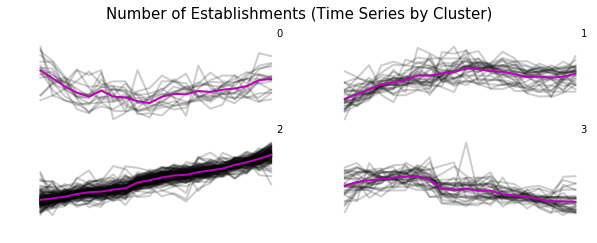

In [45]:
plt.figure(figsize=(10,5))
plt.suptitle('Number of Establishments (Time Series by Cluster)', fontsize=15)
n=320
for x in range(4):
    n+=1
    plt.subplot(n)
    seg = vals[vals.Cluster_Number == x]
    for i in range(len(seg)):
        plt.plot(range(1994,2014), seg.iloc[i][0:-1], c='k', alpha=0.2, linewidth=2)
    plt.plot(range(1994,2014), seg.mean()[0:-1], c='m', alpha=1, linewidth=2)
    plt.axis('off')
    plt.title('{}'.format(x), fontsize=10, loc='right')

#### Figure 1. Time Series of Number of Establishments by Cluster. 

The magenta lines plot the means of 4 Clusters of the establishments in zipcodes. 
We can see that number of establishments has visibly increased in zipcodes in Cluster 2 (and in zipcodes in cluster 1 to some extent). Similarly, number of establishments decreased in zipcodes in Cluster 3. 
We can see that the cluster 2 looks denser compared to the other clusters. This can mean that there are a lot of zipcodes that had seen increases in number of establishments 

### Map of the clusters

In [102]:
# Prepare of dataframe that has geometries and cluster numbers

clean = zips.join(vals)
clean = clean[['ZIPCODE', 'Cluster_Number']]

map_df = zipshp.merge(clean, on='ZIPCODE', how='left')
map_df.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,Cluster_Number
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,...",2.0
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",2.0
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1...",2.0
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,...",2.0
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,...",2.0


In [103]:
map_df.dropna(how='all', inplace=True)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


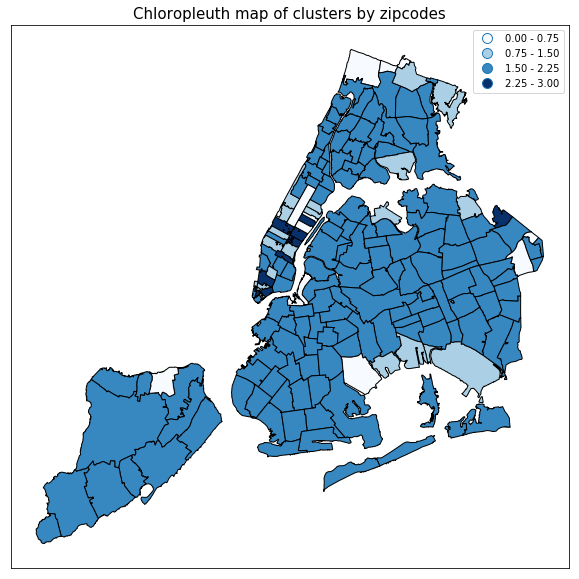

In [108]:
# Chloropleuth map of clusters by zipcodes
fig, ax = plt.subplots(1, figsize=(10,10))
map_df.plot('Cluster_Number', ax=ax, legend=True, cmap='Blues', scheme='equal_interval', k=4, edgecolor='black')
plt.title('Chloropleuth map of clusters by zipcodes', fontsize=15)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)



#### Figure 2: 
Choropleth of  cluster centers for 4 k-means clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. The business pattern time series are plotted in Figure 1. Note that the legend is somewhat misleading -- as Cluster is a categorical variable (and not continous). Here, the lightest color corresponds to Cluster 0, one shade above is Cluster 1, one shade above that one is Cluster 2 and the darkest one is Cluster 3.

In Figure 1, we noted that zipcodes in cluster 2 saw increases in the number of businesses. From this map, we can see that most of New York City saw increases in number of establishments. Particularly, all outer boroughs witnessed this trend. In Manhattan, there were some decreases in the Financial District and in Midtown. 

## Agglomerative clustering

In [112]:
vals.head()
agg_vals = vals.drop('Cluster_Number', axis=1)

In [118]:
agc = AgglomerativeClustering(n_clusters=4, linkage='average').fit(agg_vals)
labelsag = agc.labels_
centroidsag = np.zeros((4, agg_vals.shape[1]))



In [119]:
agc.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 2, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 3, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 3, 2, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 3, 1, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 3, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1])

In [121]:
agg_vals['Agg_Cluster_Number'] = agc.labels_

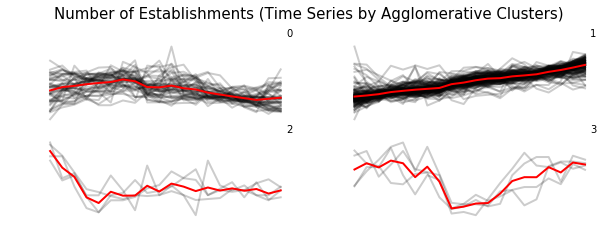

In [122]:
plt.figure(figsize=(10,5))
plt.suptitle('Number of Establishments (Time Series by Agglomerative Clusters)', fontsize=15)
n=320
for x in range(4):
    n+=1
    plt.subplot(n)
    seg = agg_vals[agg_vals.Agg_Cluster_Number == x]
    for i in range(len(seg)):
        plt.plot(range(1994,2014), seg.iloc[i][0:-1], c='k', alpha=0.2, linewidth=2)
    plt.plot(range(1994,2014), seg.mean()[0:-1], c='r', alpha=1, linewidth=2)
    plt.axis('off')
    plt.title('{}'.format(x), fontsize=10, loc='right')

#### Figure 3. Time Series of Number of Establishments by Agglomerative Clusters

The red lines plot the means of 4 agglomerative clusters for the establishments in zipcodes. We can see that number of businesses increased in cluster 1 (and it also looks like the densest cluster similar to Cluster 2 in the previous graphs). We can see that the other 3 stayed about the same throughout the time series, but there are interesting drops in the beginning of Cluster 2 Time Series and in the middle of Cluster 3 Time Series. 

### Map of Agglomerative Clusters

In [125]:
# Prepare of dataframe that has geometries and cluster numbers

clean_2 = zips.join(agg_vals)
clean_2 = clean_2[['ZIPCODE', 'Agg_Cluster_Number']]

agg_map_df = zipshp.merge(clean_2, on='ZIPCODE', how='left')
agg_map_df.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,Agg_Cluster_Number
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,...",1.0
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",1.0
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1...",1.0
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,...",1.0
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,...",1.0


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


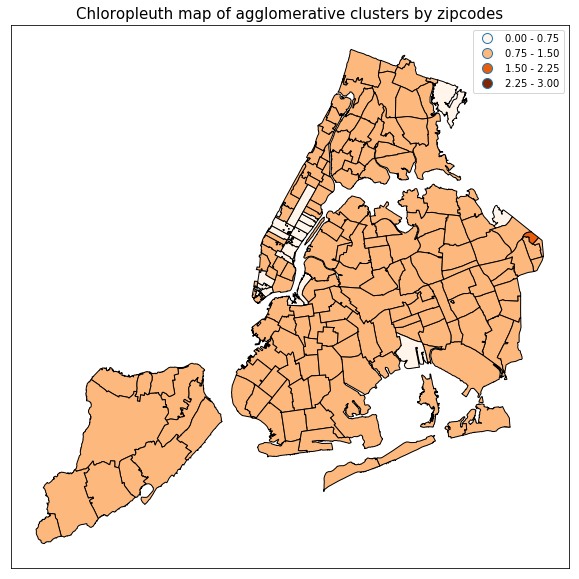

In [128]:
# Chloropleuth map of agglomerative clusters by zipcodes
fig, ax = plt.subplots(1, figsize=(10,10))

agg_map_df.plot('Agg_Cluster_Number', ax=ax, legend=True, 
            cmap='Oranges', scheme='equal_interval', k=4,
            edgecolor='black')
plt.title('Chloropleuth map of agglomerative clusters by zipcodes', fontsize=15)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


#### Figure 4:

Choropleth of cluster centers for 4 agglomerative clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. The business pattern time series are plotted at the top. Note that the legend is somewhat misleading -- as Cluster is a categorical variable (and not continous). Here, the lightest color corresponds to Cluster 0, one shade above is Cluster 1, one shade above that one is Cluster 2 and the darkest one is Cluster 3.

In Figure 3, we noted that zipcodes in cluster 1 saw increases in the number of businesses. From this map, we can see that most of New York City saw increases in number of establishments. 

This is consistent with the findings we had after doing K-Means clustering

### And if you use hierarchical clustering in scipy you can make a dandrogram it may look like this:

In [138]:
clean_3 = zips.join(agg_vals)
clean_3.drop('Agg_Cluster_Number', axis=1, inplace=True)
clean_3.head()

,ZIPCODE,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,11436,-1.279776,-1.333890,-1.171550,-1.279776,-1.279776,-0.900984,-0.522192,-0.955097,0.181279,...,0.505958,0.397732,0.289505,0.505958,0.830637,0.938863,1.263543,1.425882,1.101203,1.317656
1,11213,-1.452072,-1.312784,-1.183446,-0.954616,-0.755634,-0.785482,-0.745685,-0.586500,-0.059197,...,0.179581,0.040294,0.129836,0.040294,0.398462,0.686986,1.224237,1.214288,1.731641,2.020165
2,11212,-1.063574,-1.206598,-1.102581,-0.777527,-0.881544,-0.595498,-0.868542,-0.777527,-0.127421,...,-0.010402,0.002600,-0.218436,0.002600,0.197632,0.782728,1.458839,1.640869,1.744886,1.874907
3,11225,-1.245223,-1.174371,-1.162563,-0.902772,-0.831920,-0.914581,-0.820112,-0.761068,-0.087975,...,0.065538,0.053729,0.148199,0.325329,0.396181,0.667780,1.104700,1.305447,1.612473,2.202906
4,11218,-1.504638,-1.353797,-1.182844,-1.052115,-0.835910,-0.680041,-0.619705,-0.524172,-0.282827,...,0.054051,0.240088,0.235060,0.466350,0.566910,0.868592,0.954069,1.200442,1.612741,2.025039


KeyError: -122

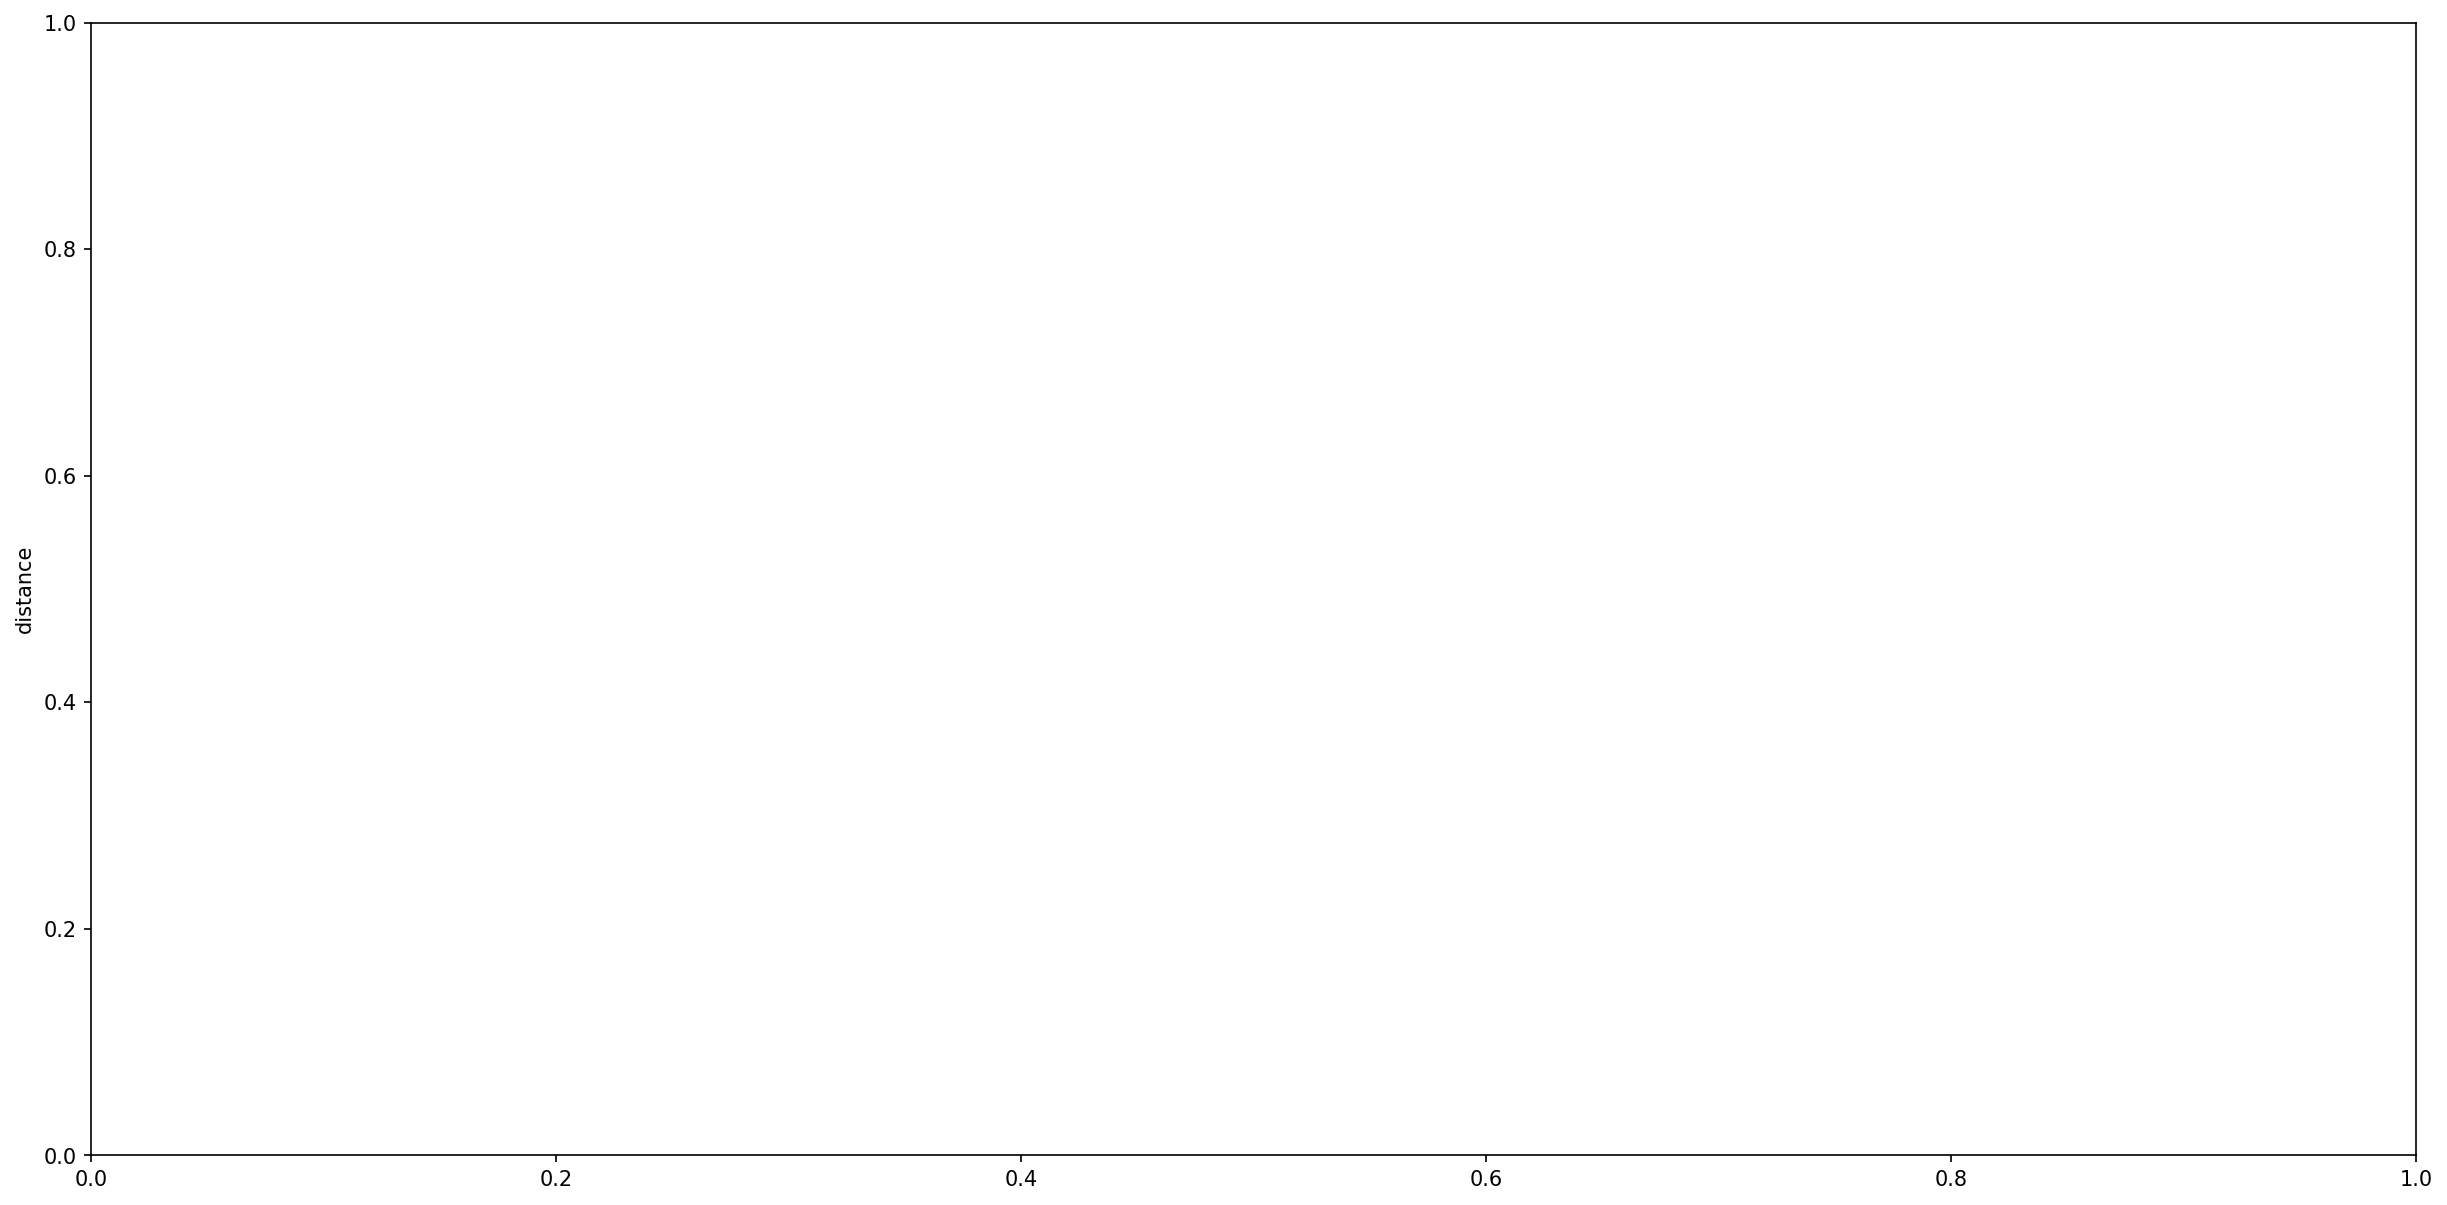

In [140]:
fig = plt.figure(figsize=(20,10), dpi=150)
plt.ylabel("distance")
ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(clean_3, method='ward'), labels = clean_3.ZIPCODE,
                               leaf_rotation=90., leaf_font_size=8.)  

In [ ]:
!pwd